# Load dataset

In [1]:
import os

dataset_folder = 'dataset/'
filenames = []
for filename in os.listdir(dataset_folder):
    if filename.find("_all.csv") > -1:
        filenames.append(filename)

In [2]:
filenames

['test_all.csv', 'train_all.csv']

In [3]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt


In [4]:
train_df = pd.read_csv(dataset_folder + "train_all.csv", header=None)
test_df = pd.read_csv(dataset_folder + "test_all.csv" , header=None)

In [5]:
train_df.info(), test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22440 entries, 0 to 22439
Columns: 301 entries, 0 to 300
dtypes: float64(300), int64(1)
memory usage: 51.5 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9408 entries, 0 to 9407
Columns: 301 entries, 0 to 300
dtypes: float64(301)
memory usage: 21.6 MB


(None, None)

- 1 sequence terdiri dari 300 titik data , kolom terakhir merupakan label untuk tiap sequence

In [6]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
0,0.833904,0.207152,-0.397542,-0.668491,-0.634373,-0.546505,-0.427151,-0.324006,-0.294306,-0.293491,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1.000000,0.778792,0.197233,-0.654853,-0.752628,-0.701510,-0.627383,-0.488274,-0.260168,-0.056887,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.674936,0.488537,-0.049248,-0.626829,-0.884667,-0.843798,-0.636090,-0.384375,-0.250414,-0.111268,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.469226,0.181124,-0.403801,-0.702536,-0.506650,-0.337309,-0.155400,-0.136786,-0.138115,-0.139813,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.784225,0.635789,0.161298,-0.408026,-0.840968,-0.476333,-0.281531,-0.145781,-0.042994,-0.015484,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


## Add Noise

- pada bagian ini kita tambahkan gaussian noise pada signal ECG 
- Noise yang akan ditambahkan adalah Additive White Gaussian Noise (AWGN)
- Pada AWGN nilai rata-rata $\mu$ = 0, sehingga untuk tiap Gaussian random variable $X$, non-central second [moment](https://en.wikipedia.org/wiki/Normal_distribution#Moments) *E*[$X^{2}$] adalah: <br><br>

*E*[$X^{2}$] = $\mu^{2}$ + $\sigma^{2}$ <br><br>

sehingga, <br>
*E*[$X^{2}$] = $\sigma^{2}$ <br><br>

untuk, <br>
*E*[$X^{2}$] dalam konteks ini merupakan rata-rata noise, <br><br>

$NoiseAvg$ = $10^{NoiseAvg[db]/10}$ <br><br>

konversi baliknya ke-db, <br>
$NoiseAvg[db] = 10\times log(NoiseAvg)$ <br><br>

NoiseAvg bisa didapatkan dari formula $SNR$, <br>
$SNR[db]= Signal[db] - NoiseAvg[db]$  <br><br><br>


sehingga jika $SNR$ diset pada nilai tertentu, bisa didapatkan variance $\sigma^{2}$ yang nantinya dapat digunakan untuk menghasilkan white noise. 

- untuk menghasilkan white noise bisa digunakan library `numpy.random.normal()` dengan parameter `step` = $\sigma$ (std deviation)

In [7]:
def add_AWGN_noise(signal, target_noise_db = -30):
    
    mean_noise = 0
    target_noise_watts = 10 ** (target_noise_db / 10)
    sigma = np.sqrt(target_noise_watts)
    
    noise = np.random.normal(mean_noise, sigma, len(signal))

    return (signal+noise)

In [8]:
def plot_noised_signal(signal, noised_signal):
    plt.figure(figsize=(15,4)) 

    plt.subplot(1,2,1)
    plt.plot(signal)
    plt.title("Original Signal")

    plt.subplot(1,2,2)
    plt.plot(noised_signal)
    plt.title("Noised Signal with AWGN")

    plt.tight_layout()
    plt.show()

In [9]:
X_train=train_df.iloc[:,:300].values
X_test=test_df.iloc[:,:300].values
y_train=train_df.iloc[:,300].values
y_test=test_df.iloc[:,300].values


- Apply noise to training data only

In [10]:
X_train_noised = train_df.iloc[:,:300].apply(add_AWGN_noise, axis=1).values

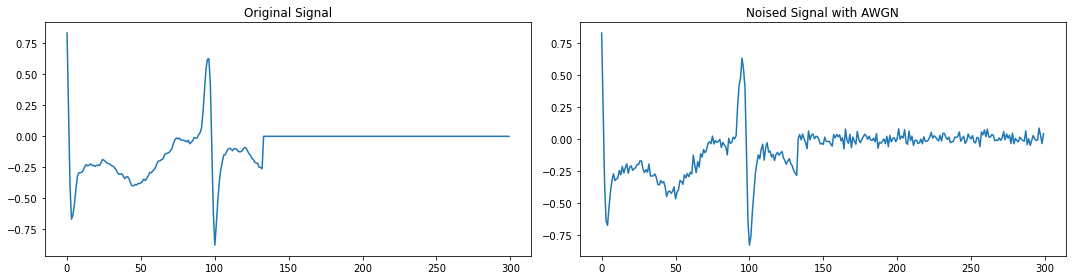

In [11]:
plot_noised_signal(X_train[0], X_train_noised[0])

### Save Model Adaptive Filtering

In [12]:
import pickle

def save_adapfilt_model(model, filename, path=""): 
    with open(os.path.join(path, filename), 'wb') as out_name:
        pickle.dump(model, out_name, pickle.HIGHEST_PROTOCOL)

def read_adapfilt_model(filename, path=""):
    with open(os.path.join(path, filename), 'rb') as in_name:
        model = pickle.load(in_name)
        return model

### Denoising Evaluation
- Sekarang kita akan evaluasi hasil denoising LMS diatas
- evaluasi dilakukan dengan cara mengitung SNR, RMS, EMSE
- SNR dihitung dengan cara, \
$SNR = \frac{\mu}{\sigma_{noise}}$ \
\
untuk, \
$\mu$ merupakan `mean` dari signal, \
$\sigma_{noise}$ merupakan `sandard deviation` dari noise 


- noise merupakan pengurangan signal ter-noise terhadap signal, \
$noise = signal - noisedSignal$

- Semakin besar nilai SNR, menandakan sedikitnya noise pada signal.
- Semakin kecil nilai MSE dan RMSE maka semakin sedikit noise setelah proses denoising.

In [13]:
def calc_snr(signal, noised_signal):
    #convert to dB 
    noise = signal - noised_signal
    std_noise = np.std(noise)
    signal_avg = np.mean(signal)
    
    SNR  = signal_avg/std_noise

    return SNR

## Denoising Signal

- Ditahap ini kita akan coba lakukan Denoising signal menggunakan beberapa teknik Adapive Filter seperti LMS, NLMS, RLS
- Selanjutnya di lakukan evaluasi denoising dengan menghitung SNR, MSE, dan RMSE
- Implementasi proses denoising signal di Python dapat dilakukan menggunakan library `padasip`
- Contoh penerapanya dapat dilihat disini : [Adaptive Signal Processing menggunakan Python](https://medium.com/@yunusmuhammad007/adaptive-signal-processing-menggunakan-python-44c341a453c3)


- Pertama kita akan coba terapkan denoising signal ECG menggunakan Adaptive FIlter LMS (least-mean-squares)

In [14]:
import padasip as pa
from padasip.filters import AdaptiveFilter

- Create Adaptive Filtering class with Standard Scaler Scikit-Learn style

In [15]:
class adapfilt_modeler():
    def __init__(self, model='lms', mu=0.1):
        self._model_name = model
        self._model = AdaptiveFilter(model=model, n=1, mu=mu, w="random")
        #self._output = []
    
    def fit(self, noised_signals, signals):
        print('------------------- %s model training ----------------------' % self._model_name.upper())
        for i, (s, ns) in enumerate(zip(signals, noised_signals)):
            x = np.reshape(s, (s.shape[0], 1))
            d = np.reshape(ns, (ns.shape[0], 1))
            y, e, w = self._model.run(d, x) 
            #self._output.append([y, e, w, d, x])
            
            snr = calc_snr(y, x)
            mse = pa.misc.MSE(e)
            rmse = pa.misc.RMSE(e)
            if i % int(signals.shape[0]/10) == 0 :
                print("sample %d \t : SNR %.4f, MSE %.4f, RMSE %.4f" % (i, snr, mse, rmse))
                
    def fit_transform(self, noised_signals, signals):
        self.fit(noised_signals, signals)
        
        return self.transform(noised_signals)
    
    def transform(self, signals):
        vec = np.vectorize(self._model.predict)   
        result = vec(signals)
        
        return result

### Train model Adaptive Filtering

In [16]:
adapfilt_lms = adapfilt_modeler(model='lms')

In [17]:
adapfilt_lms.fit(X_train_noised, X_train)

------------------- LMS model training ----------------------
sample 0 	 : SNR -0.1775, MSE 0.0164, RMSE 0.1280
sample 2244 	 : SNR 0.3215, MSE 0.0010, RMSE 0.0315
sample 4488 	 : SNR 0.4515, MSE 0.0011, RMSE 0.0335
sample 6732 	 : SNR 0.5257, MSE 0.0010, RMSE 0.0319
sample 8976 	 : SNR 0.3593, MSE 0.0009, RMSE 0.0304
sample 11220 	 : SNR 0.3770, MSE 0.0011, RMSE 0.0326
sample 13464 	 : SNR 0.2419, MSE 0.0011, RMSE 0.0334
sample 15708 	 : SNR 0.3024, MSE 0.0010, RMSE 0.0322
sample 17952 	 : SNR 0.3281, MSE 0.0011, RMSE 0.0337
sample 20196 	 : SNR 0.3117, MSE 0.0010, RMSE 0.0321


In [18]:
X_train_denoised_lms = adapfilt_lms.transform(X_train)

In [19]:
adapfilt_nlms = adapfilt_modeler(model='nlms')

In [20]:
adapfilt_nlms.fit(X_train_noised, X_train)

------------------- NLMS model training ----------------------
sample 0 	 : SNR -0.1835, MSE 0.0147, RMSE 0.1214
sample 2244 	 : SNR 0.3217, MSE 0.0010, RMSE 0.0315
sample 4488 	 : SNR 0.4515, MSE 0.0011, RMSE 0.0335
sample 6732 	 : SNR 0.5255, MSE 0.0010, RMSE 0.0319
sample 8976 	 : SNR 0.3596, MSE 0.0009, RMSE 0.0304
sample 11220 	 : SNR 0.3772, MSE 0.0011, RMSE 0.0326
sample 13464 	 : SNR 0.2422, MSE 0.0011, RMSE 0.0334
sample 15708 	 : SNR 0.3024, MSE 0.0010, RMSE 0.0322
sample 17952 	 : SNR 0.3281, MSE 0.0011, RMSE 0.0337
sample 20196 	 : SNR 0.3118, MSE 0.0010, RMSE 0.0321


In [21]:
X_train_denoised_nlms = adapfilt_nlms.transform(X_train)

In [22]:
adapfilt_rls = adapfilt_modeler(model='rls', mu=0.99)

In [23]:
adapfilt_rls.fit(X_train_noised, X_train)

------------------- RLS model training ----------------------
sample 0 	 : SNR -0.3367, MSE 0.0052, RMSE 0.0723
sample 2244 	 : SNR 0.3213, MSE 0.0010, RMSE 0.0316
sample 4488 	 : SNR 0.4500, MSE 0.0011, RMSE 0.0336
sample 6732 	 : SNR 0.5255, MSE 0.0010, RMSE 0.0320
sample 8976 	 : SNR 0.3592, MSE 0.0009, RMSE 0.0305
sample 11220 	 : SNR 0.3773, MSE 0.0011, RMSE 0.0326
sample 13464 	 : SNR 0.2414, MSE 0.0011, RMSE 0.0335
sample 15708 	 : SNR 0.3037, MSE 0.0010, RMSE 0.0322
sample 17952 	 : SNR 0.3292, MSE 0.0011, RMSE 0.0338
sample 20196 	 : SNR 0.3115, MSE 0.0010, RMSE 0.0321


In [24]:
X_train_denoised_rls = adapfilt_rls.transform(X_train)

- Plot Training adaptation

In [25]:
def plot_denoising_train(d, y, x, e, model='lms'):
    # show results
    snr= calc_snr(y, d)
    mse = pa.misc.MSE(e)
    rmse = pa.misc.RMSE(e)
        
    plt.figure(figsize=(15,5))
    
    plt.subplot(1,2,1)
    plt.grid()
    plt.title("Adaptation Result %s | SNR : %.4f, MSE : %.4f, RMSE : %.4f" % (model.upper(), snr, mse, rmse))
    plt.xlabel("samples - n")
    plt.plot(y,"b", label="y - denoised signal")
    plt.plot(x,"g", label="x - original signal")
    plt.plot(d,"r", label="d - noised signal")
    plt.legend()

    plt.subplot(1,2,2)
    plt.grid()
    plt.title("Filter Error Graph")
    plt.xlabel("samples - n")
    plt.plot(pa.misc.logSE(e),"r", label="e - error [dB]")
    plt.legend()

    plt.tight_layout()
    plt.show()

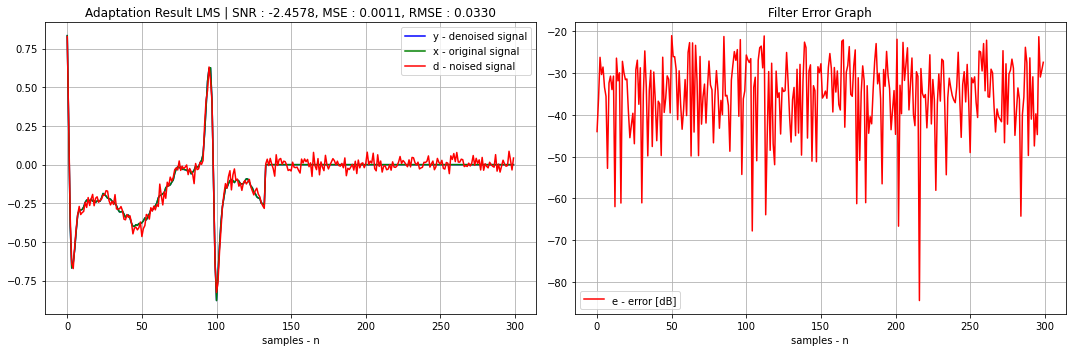

In [26]:
idx = 0

y = X_train_denoised_lms[idx]
x = X_train[idx]
d = X_train_noised[idx]
e = d - y

plot_denoising_train(d, y, x, e, model='lms')

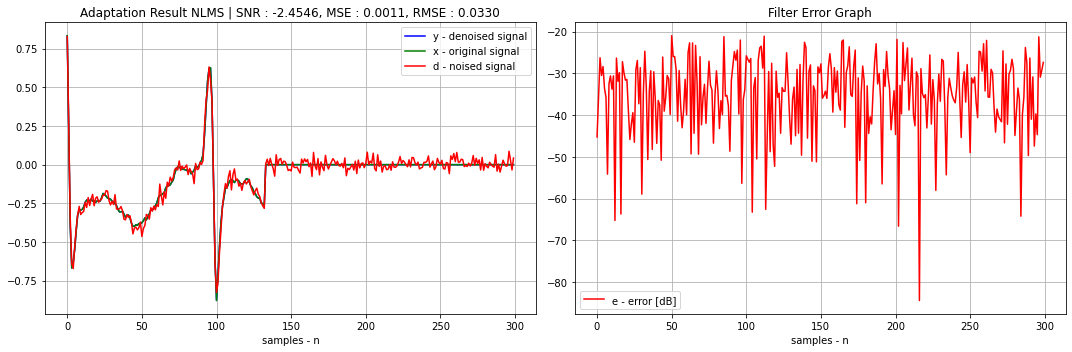

In [27]:
idx = 0

y = X_train_denoised_nlms[idx]
x = X_train[idx]
d = X_train_noised[idx]
e = d - y

plot_denoising_train(d, y, x, e, model='nlms')

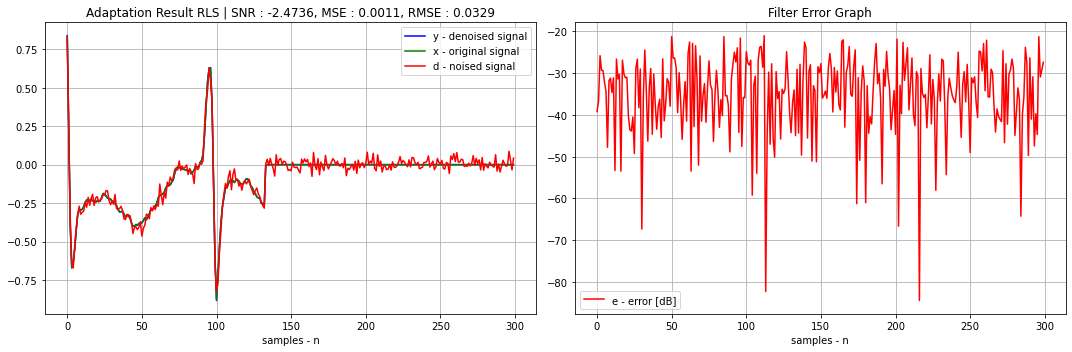

In [28]:
idx = 0

y = X_train_denoised_rls[idx]
x = X_train[idx]
d = X_train_noised[idx]
e = d - y

plot_denoising_train(d, y, x, e, model='rls')

### Save & Load Model

- Save model

In [29]:
save_adapfilt_model(adapfilt_lms, "LMS_adapfilt_model_afdb.pkl")

In [30]:
save_adapfilt_model(adapfilt_nlms, "NLMS_adapfilt_model_afdb.pkl")

In [31]:
save_adapfilt_model(adapfilt_rls, "RLS_adapfilt_model_afdb.pkl")

- Load model LMS

In [32]:
model_lms = read_adapfilt_model("LMS_adapfilt_model_afdb.pkl")

In [33]:
model_nlms = read_adapfilt_model("NLMS_adapfilt_model_afdb.pkl")

In [34]:
model_rls = read_adapfilt_model("RLS_adapfilt_model_afdb.pkl")

### Test model Adaptive Filtering

In [35]:
X_test_denoised_lms = adapfilt_lms.transform(X_test)

In [36]:
X_test_denoised_nlms = adapfilt_nlms.transform(X_test)

In [37]:
X_test_denoised_rls = adapfilt_rls.transform(X_test)

- Plot Result

In [38]:
def plot_denoising_test(y, x, model='lms'):
    # show results
    plt.figure(figsize=(8,5))
    plt.grid()
    plt.title("Adaptation Result %s - Test Dataset" % model.upper())
    plt.xlabel("samples - n")
    plt.plot(y,"b", label="y - denoised signal")
    plt.plot(x,"g", label="x - original signal")
    plt.legend()
    plt.tight_layout()
    plt.show()

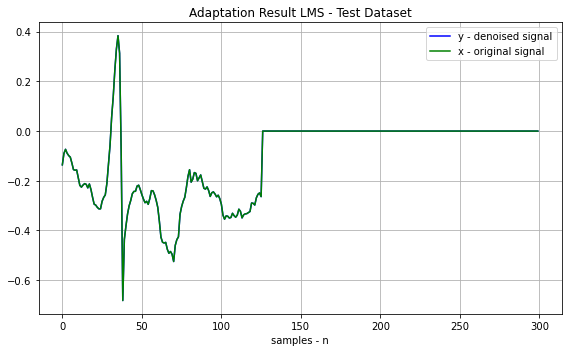

In [39]:
idx = 0
y = X_test_denoised_lms[idx]
x = X_test[idx]

plot_denoising_test(y, x, model='lms')

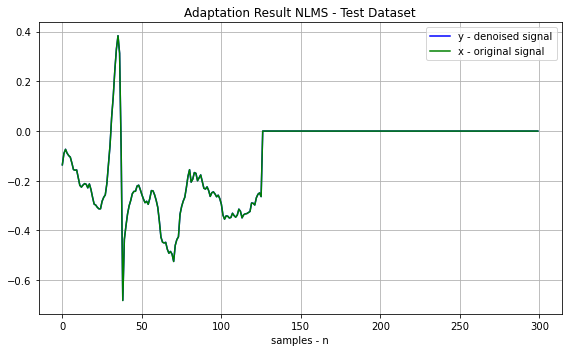

In [40]:
idx = 0
y = X_test_denoised_nlms[idx]
x = X_test[idx]

plot_denoising_test(y, x, model='nlms')

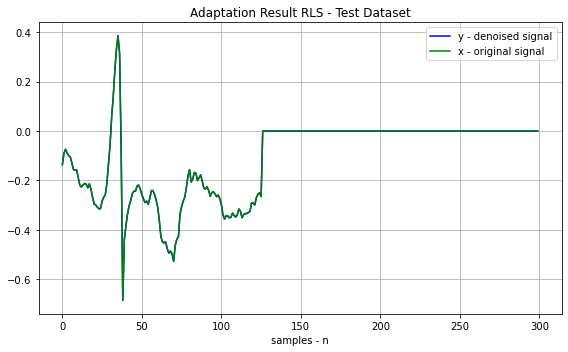

In [41]:
idx = 0
y = X_test_denoised_rls[idx]
x = X_test[idx]

plot_denoising_test(y, x, model='rls')

### Save Denoised Train and Test data

In [42]:
train_lms_df = pd.DataFrame(np.hstack((X_train_denoised_lms, np.expand_dims(y_train, 1))))
train_nlms_df = pd.DataFrame(np.hstack((X_train_denoised_nlms, np.expand_dims(y_train, 1))))
train_rls_df = pd.DataFrame(np.hstack((X_train_denoised_rls, np.expand_dims(y_train, 1))))

test_lms_df = pd.DataFrame(np.hstack((X_test_denoised_lms, np.expand_dims(y_test, 1))))
test_nlms_df = pd.DataFrame(np.hstack((X_test_denoised_nlms, np.expand_dims(y_test, 1))))
test_rls_df = pd.DataFrame(np.hstack((X_test_denoised_rls, np.expand_dims(y_test, 1))))

In [43]:
train_lms_df.to_csv(dataset_folder + "train_all_lms.csv", index=None, header=None)
train_nlms_df.to_csv(dataset_folder + "train_all_nlms.csv", index=None, header=None)
train_rls_df.to_csv(dataset_folder + "train_all_rls.csv", index=None, header=None)

test_lms_df.to_csv(dataset_folder + "test_all_lms.csv", index=None, header=None)
test_nlms_df.to_csv(dataset_folder + "test_all_nlms.csv", index=None, header=None)
test_rls_df.to_csv(dataset_folder + "test_all_rls.csv", index=None, header=None)